In [1]:
# 匯入工具模組
from jettool import tools
import pandas
import numpy

In [2]:
# 初始化物件，可同時set Key
tejtool = tools.financial_tool(api_key="GDEy0mWAGqnI3EemCREGREZMcEVbnF")

['使用者名稱：趙育祥(ZYX)', '使用權限日期：2018-01-01/2050-12-31', '日連線次數狀態：1334/100000', '日查詢資料量狀態：9854211/10000000', '月查 詢資料量狀態：53848832/9223372036854775807']


In [5]:
# 使用query_data函式，此函式可自動判斷新增查詢
# 把window改成更大的值，或改base_date，也只會查詢異動，不會整個重新查
# 以column_name指定要查詢的資料欄位，會自動按照key的權限去查可以用的table來拼湊
data_name = ['常續性稅後淨利','收盤價(元)','報酬率-Ln','單月營收(千元)']
data = tejtool.query_data(base_date='2019-12-31',window='12m',column_names=data_name)
data[data['coid']=='2330']

資料起始日：2018-12-31
查詢財報資料
成功查詢會計家數:1970
最大財報資料日期:2019-09-01
查詢日資料 最大資料日期:2019-12-31
借券餘額 重新查詢:False
上市(櫃)調整股價(日)-除權息調整 重新查詢:False


,zdate,mdate,coid,收盤價(元),常續性稅後淨利,報酬率-Ln,單月營收(千元)
144838,2019-01-03,2018-12-01,2330,215.5,0.0,-1.8391,NaN
144839,2019-01-04,2018-12-01,2330,208.0,0.0,-3.5423,NaN
144840,2019-01-07,2018-12-01,2330,213.0,0.0,2.3754,NaN
144841,2019-01-08,2018-12-01,2330,211.0,0.0,-0.9434,NaN
144842,2019-01-09,2018-12-01,2330,215.5,0.0,2.1103,NaN
...,...,...,...,...,...,...,...
145074,2019-12-25,2019-09-01,2330,333.0,101717149.0,0.3008,NaN
145075,2019-12-26,2019-09-01,2330,333.0,101717149.0,0.0000,NaN
145076,2019-12-27,2019-09-01,2330,338.0,101717149.0,1.4903,NaN
145077,2019-12-30,2019-09-01,2330,334.5,101717149.0,-1.0409,NaN


In [21]:
# 使用get_data來取得特定基準日(base_date)時可觀察到的資料
# 指定欄位、window(資料長度)
data = tejtool.get_data(base_date='2019-08-16',window='5d',column_names=['常續性稅後淨利','收盤價(元)','報酬率-Ln','單月營收(千元)'])

2019-08-15
[numpy.datetime64('2019-08-15'), numpy.datetime64('2019-08-16')]


In [22]:
# 計算益本比，因為打算用這個來作分類
data['EP'] = data['常續性稅後淨利']/data['收盤價(元)']

In [23]:
# 因為涉及除法，會有無限大的問題，所以要作處理
data = data.dropna().replace([numpy.inf, -numpy.inf], numpy.nan).fillna(0)
data.describe()

,收盤價(元),單月營收(千元),常續性稅後淨利,報酬率-Ln,EP
count,4284.000000,4.284000e+03,4.284000e+03,4284.000000,4284.000000
mean,51.100644,3.112182e+06,4.768368e+05,0.005072,10179.833156
std,144.215484,1.600786e+07,2.614455e+06,1.921126,58226.941597
min,0.000000,-5.218000e+03,-4.902445e+06,-10.536100,-779259.868421
25%,14.700000,1.816080e+05,0.000000e+00,-0.917625,0.000000
50%,26.175000,4.616320e+05,6.389850e+04,0.000000,1769.589905
75%,48.837500,1.389523e+06,2.341880e+05,0.727725,5438.687034
max,3855.000000,3.980121e+08,6.640827e+07,9.531000,628547.619048


In [28]:
data[['EP','報酬率-Ln']].values

array([[ 1.04899058e+02,  0.00000000e+00],
       [ 4.31335150e+01, -1.21870000e+00],
       [ 4.36088154e+01, -1.09590000e+00],
       ...,
       [ 1.96627624e+05,  2.77980000e+00],
       [ 1.98179947e+05, -7.86400000e-01],
       [ 1.98441054e+05, -7.86400000e-01]])

In [24]:
# 使用sklearn的資料標準化套件產生配適用樣本X
from sklearn.preprocessing import StandardScaler
X = data[['EP','報酬率-Ln']].values
X = StandardScaler().fit_transform(X)

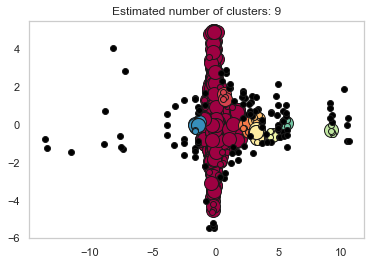

In [25]:
# 嘗試以DBSCAN來做資料分類，直接複製sklearn的範例程式
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.3, min_samples=5).fit(X)
core_samples_mask = numpy.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in numpy.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()